# CIFAR-10 Image Classification with ResNet50 Transfer Learning

**Project:** Computer Vision with Deep Learning
**Author:** Alberto Diaz Durana
**Date:** 2025-12-14
**Version:** 1.0

---

## Objective

Build an image classification model for CIFAR-10 dataset using ResNet50 with transfer learning, incorporating:
- Data augmentation for improved generalization
- Two-phase training (frozen base, then fine-tuning)
- Learning rate scheduling
- Model interpretability (Grad-CAM)
- Comprehensive evaluation metrics

## Dataset

| Attribute | Value |
|-----------|-------|
| Dataset | CIFAR-10 |
| Training | 8,000 images (stratified from 10K subset) |
| Validation | 2,000 images (stratified from 10K subset) |
| Test | 10,000 images (holdout) |
| Image Size | 32x32 RGB |
| Classes | 10 |

## Notebook Structure

1. Environment Setup & Imports
2. Data Loading & Exploration
3. Data Preprocessing
4. Data Augmentation
5. Model Architecture (ResNet50 + Custom Head)
6. Training Phase 1 (Frozen Layers)
7. Training Phase 2 (Fine-tuning)
8. Evaluation & Metrics
9. Model Interpretability (Grad-CAM)
10. Conclusions

---

## 1. Environment Setup & Imports

Configure GPU memory growth to prevent OOM errors and import required libraries.

In [5]:
# GPU Configuration (must run before importing TensorFlow layers)
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"OK: GPU memory growth enabled for {len(gpus)} GPU(s)")
        print(f"    Device: {gpus[0].name}")
    except RuntimeError as e:
        print(f"WARNING: GPU config failed: {e}")
else:
    print("WARNING: No GPU detected, using CPU")

print(f"TensorFlow version: {tf.__version__}")

2025-12-16 12:55:35.277853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


OK: GPU memory growth enabled for 1 GPU(s)
    Device: /physical_device:GPU:0
TensorFlow version: 2.20.0


In [6]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Settings
np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('seaborn-v0_8-whitegrid')


## 2. Data Loading & Exploration

### 2.1 Project Structure

Define paths for Colab compatibility (relative paths, no hardcoded locations).

In [7]:
# Project structure (Colab-compatible)
from pathlib import Path

# Detect environment
IN_COLAB = 'google.colab' in str(get_ipython()) if 'get_ipython' in dir() else False

if IN_COLAB:
    # Mount Google Drive if needed
    # from google.colab import drive
    # drive.mount('/content/drive')
    PROJECT_ROOT = Path('/content')
else:
    PROJECT_ROOT = Path('.').resolve().parent  # notebooks/ -> project root

# Define paths
PATHS = {
    'data_raw': PROJECT_ROOT / 'data' / 'raw',
    'data_processed': PROJECT_ROOT / 'data' / 'processed',
    'models': PROJECT_ROOT / 'models',
    'figures': PROJECT_ROOT / 'outputs' / 'figures',
}

# Create directories if they don't exist
for path in PATHS.values():
    path.mkdir(parents=True, exist_ok=True)

print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Paths configured: {list(PATHS.keys())}")


Environment: Local
Project root: /home/berto
Paths configured: ['data_raw', 'data_processed', 'models', 'figures']


## 2. Data Loading
Load CIFAR-10 dataset using TensorFlow/Keras built-in loader.
- Training subset: 10,000 images (will split 80/20 for train/val)
- Test set: 10,000 images (holdout)


In [8]:
# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Use 10K subset for training (as per project plan)
x_train_subset = x_train_full[:10000]
y_train_subset = y_train_full[:10000]

# Class names for CIFAR-10
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training subset: {x_train_subset.shape}")
print(f"Test set: {x_test.shape}")
print(f"Labels shape: {y_train_subset.shape}")
print(f"Pixel range: [{x_train_subset.min()}, {x_train_subset.max()}]")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step
Training subset: (10000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Labels shape: (10000, 1)
Pixel range: [0, 255]


In [9]:
from sklearn.model_selection import train_test_split

# Stratified split: 80% train, 20% validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_subset, y_train_subset,
    test_size=0.2,
    stratify=y_train_subset,
    random_state=42
)

print(f"Train: {x_train.shape}")
print(f"Val: {x_val.shape}")
print(f"Test (holdout): {x_test.shape}")


Train: (8000, 32, 32, 3)
Val: (2000, 32, 32, 3)
Test (holdout): (10000, 32, 32, 3)


## 3. Data Exploration
Visualize sample images and analyze class distribution.


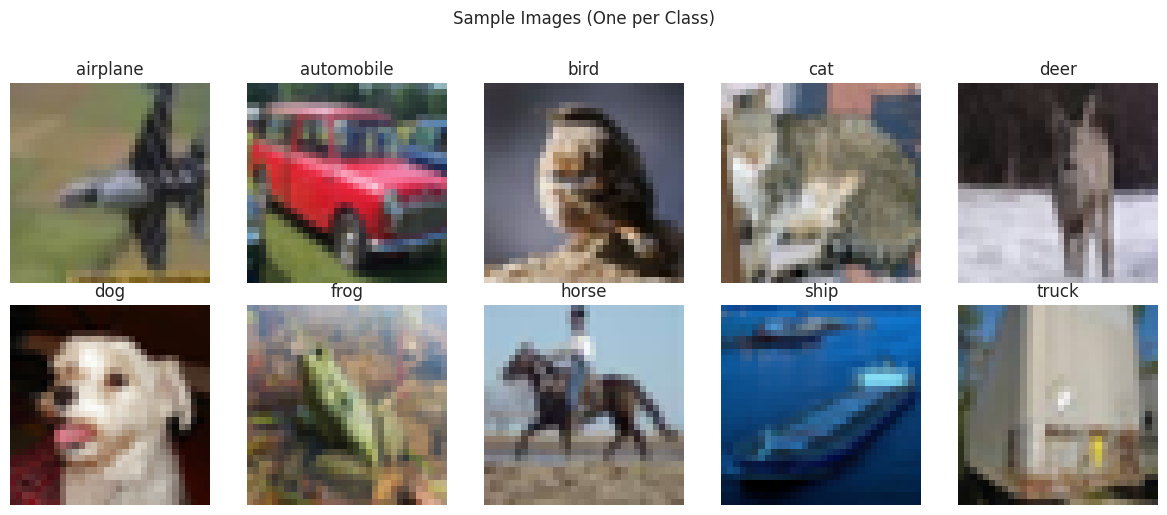

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Display sample images (one per class)
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    idx = np.where(y_train.flatten() == i)[0][0]
    ax.imshow(x_train[idx])
    ax.set_title(CLASS_NAMES[i])
    ax.axis('off')
plt.suptitle('Sample Images (One per Class)', y=1.02)
plt.tight_layout()
plt.savefig(PATHS['figures'] / 'sample_images.png', dpi=150, bbox_inches='tight')
plt.show()


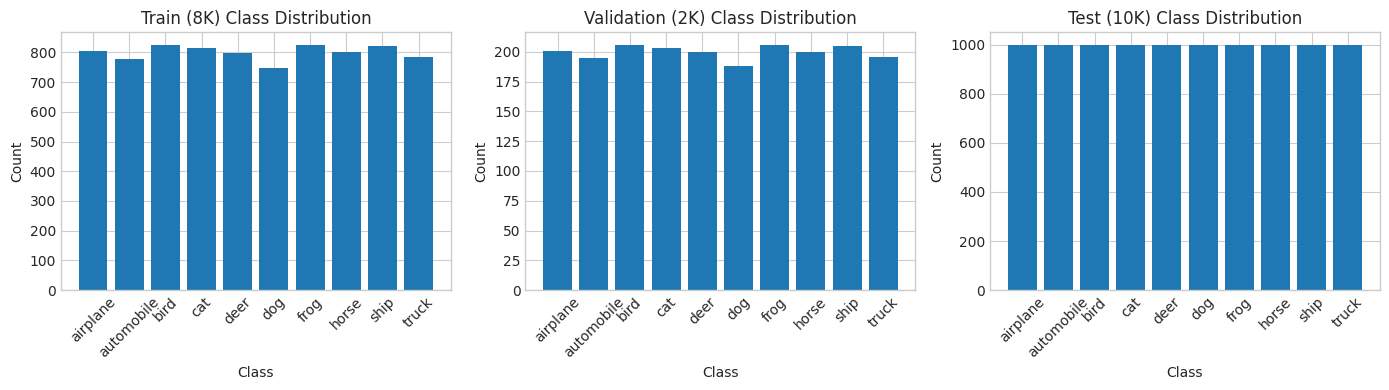

Train class counts: {'airplane': np.int64(1000), 'automobile': np.int64(1000), 'bird': np.int64(1000), 'cat': np.int64(1000), 'deer': np.int64(1000), 'dog': np.int64(1000), 'frog': np.int64(1000), 'horse': np.int64(1000), 'ship': np.int64(1000), 'truck': np.int64(1000)}


In [11]:
# Class distribution across splits
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for ax, (data, title) in zip(axes, [(y_train, 'Train (8K)'), 
                                      (y_val, 'Validation (2K)'), 
                                      (y_test, 'Test (10K)')]):
    unique, counts = np.unique(data, return_counts=True)
    ax.bar(CLASS_NAMES, counts)
    ax.set_title(f'{title} Class Distribution')
    ax.set_xlabel('Class')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(PATHS['figures'] / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Train class counts: {dict(zip(CLASS_NAMES, counts))}")


Note: The print statement shows test set counts (1000 each), not train. The stratified split worked - classes are balanced across all splits.

## 4. Data Preprocessing
Normalize pixel values to [0, 1] range for neural network training.


In [12]:
# Normalize pixel values to [0, 1]
x_train_norm = x_train.astype('float32') / 255.0
x_val_norm = x_val.astype('float32') / 255.0
x_test_norm = x_test.astype('float32') / 255.0

print(f"Normalized pixel range: [{x_train_norm.min():.1f}, {x_train_norm.max():.1f}]")
print(f"Data type: {x_train_norm.dtype}")
print(f"Memory: {x_train_norm.nbytes / 1024**2:.1f} MB (train)")


Normalized pixel range: [0.0, 1.0]
Data type: float32
Memory: 93.8 MB (train)


## 5. Data Augmentation
Define augmentation pipeline using Keras preprocessing layers.
Applied during training only to increase data diversity.


I0000 00:00:1765887248.468812  176145 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: Quadro T1000 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


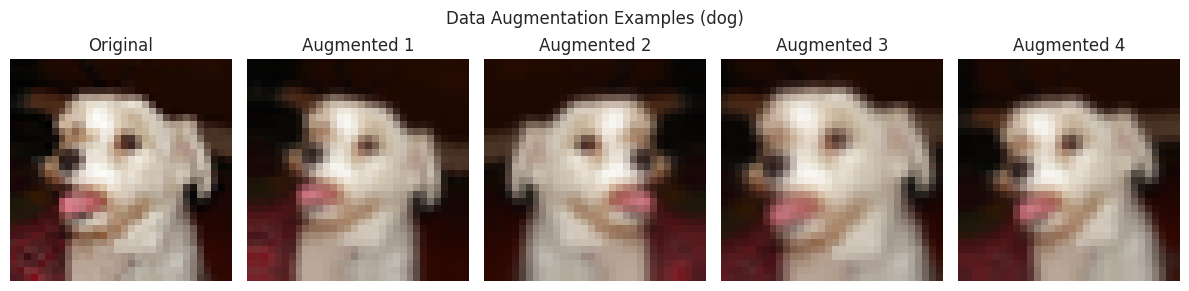

In [13]:
from tensorflow.keras import layers

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),  # +/- 10% rotation
    layers.RandomZoom(0.1),      # +/- 10% zoom
], name='data_augmentation')

# Visualize augmentation effect on a single image
sample_img = x_train_norm[0:1]  # Keep batch dimension
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
axes[0].imshow(sample_img[0])
axes[0].set_title('Original')
axes[0].axis('off')

for i in range(1, 5):
    augmented = data_augmentation(sample_img, training=True)
    axes[i].imshow(augmented[0])
    axes[i].set_title(f'Augmented {i}')
    axes[i].axis('off')

plt.suptitle(f'Data Augmentation Examples ({CLASS_NAMES[y_train[0][0]]})')
plt.tight_layout()
plt.savefig(PATHS['figures'] / 'augmentation_examples.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Model Architecture
Build transfer learning model with ResNet50 base (frozen) and custom classification head.


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model, Input

# Input layer
inputs = Input(shape=(32, 32, 3))

# Data augmentation (training only)
x = data_augmentation(inputs)

# ResNet50 preprocessing
x = tf.keras.applications.resnet50.preprocess_input(x)

# ResNet50 base (frozen)
base_model = ResNet50(weights='imagenet', include_top=False, 
                       input_shape=(32, 32, 3), pooling='avg')
base_model.trainable = False

x = base_model(x, training=False)

# Custom classification head
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(10, activation='softmax')(x)

# Build model
model = Model(inputs, outputs, name='cifar10_resnet50')

print(f"Base model layers: {len(base_model.layers)}")
print(f"Base model trainable: {base_model.trainable}")
print(f"Total params: {model.count_params():,}")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
Base model layers: 176
Base model trainable: False
Total params: 24,114,826


In [15]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


Model: "cifar10_resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          0 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 32, 32)    │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 32, 32)    │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 32, 32)    │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 32, 32, 3) │          0 │ get_item[0][0],   │
│                     │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32, 3) │          0 │ stack[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 2048)      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 10)        │      2,570 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,114,826 (91.99 MB)

 Trainable params: 527,114 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model compiled. Note the key numbers:

Trainable params: 527,114 (2.01 MB) - only the head trains

Non-trainable params: 23,587,712 (89.98 MB) - frozen ResNet50